In [99]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

save_base = "../preprocessed_data/"
models_base = "./models/"


In [102]:
class SensorDataset(Dataset):
    def __init__(self, data_type):
        UV_x = np.loadtxt(save_base + "UV_x_scaled.csv", delimiter=',')
        VIS_x = np.loadtxt(save_base + "VIS_x_scaled.csv", delimiter=',')
        IR_x = np.loadtxt(save_base + "IR_x_scaled.csv", delimiter=',')
        
        x = UV_x if data_type == "UV" else VIS_x if data_type == "VIS" else IR_x
        self.X = torch.from_numpy(x).float()
        
        y = np.loadtxt(save_base + "y.csv", delimiter=',')
        self.y = torch.from_numpy(y).float().view(-1, 1)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ix):
        x = self.X[ix]
        y = self.y[ix]
        return x, y
    
    def get_dim(self):
        return self.X.shape[1]
    
UV_dataset = SensorDataset(data_type="UV")
VIS_dataset = SensorDataset(data_type="VIS")
IR_dataset = SensorDataset(data_type="IR")

In [103]:
(h1, h2) = (1024, 512)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(UV_dataset.get_dim(), h1),
            nn.Tanh(),
            nn.Linear(h1, h2),
            nn.Tanh(),
            nn.Linear(h2, 1)
        )

    def forward(self, x):
        return self.layers(x)
    
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
      layer.reset_parameters()

In [104]:
def cross_validate(dataset):
  k_folds = 7
  epochs = 50

  kf = KFold(n_splits=k_folds, shuffle=True)
  loss_function = nn.MSELoss()

  fold_train_losses = []
  fold_test_losses = []

  for fold, (train_ids, test_ids) in enumerate(kf.split(dataset)):

    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    trainloader = DataLoader(dataset, batch_size=16, sampler=train_subsampler)
    testloader = DataLoader(dataset, batch_size=16, sampler=test_subsampler)

    network = MLP()
    network.apply(reset_weights)

    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    
    network.train(True)
    
    train_losses = []

    for epoch in range(epochs):

      for i, data in enumerate(trainloader):
        
        inputs, targets = data
        
        optimizer.zero_grad()
        
        outputs = network(inputs)
        
        loss = loss_function(outputs, targets)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(torch.sqrt(loss).item())
        
    fold_train_losses.append(train_losses)
        
    network.eval()
    
    with torch.no_grad():
      
      test_loss = 0
      
      for i, data in enumerate(testloader):
        
        inputs, targets = data
        
        outputs = network(inputs)
        
        loss = loss_function(outputs, targets)
        
        test_loss += torch.sqrt(loss).item()
        
      test_loss /= len(testloader)
      
      fold_test_losses.append(test_loss)
      
    print(f"Fold {fold}, train loss: {train_losses[-1]:.3f} test loss: {test_loss:.3f}")
    
  print(f"Mean train loss: {np.mean([fold[-1] for fold in fold_train_losses]):.3f}")
  print(f"Mean test loss: {np.mean(fold_test_losses):.3f}")
  
  plt.figure(figsize=(15, 30))

  for ix, fold in enumerate(fold_train_losses):
    plt.subplot(len(fold_train_losses), 1, ix+1)
    plt.plot(fold)
    
  plt.show()
      

Fold 0, train loss: 1.423 test loss: 2.718
Fold 1, train loss: 1.579 test loss: 0.945
Fold 2, train loss: 1.488 test loss: 3.180
Fold 3, train loss: 0.692 test loss: 1.235
Fold 4, train loss: 0.854 test loss: 1.637
Fold 5, train loss: 0.686 test loss: 2.218
Fold 6, train loss: 0.389 test loss: 1.464
Mean train loss: 1.016
Mean test loss: 1.914


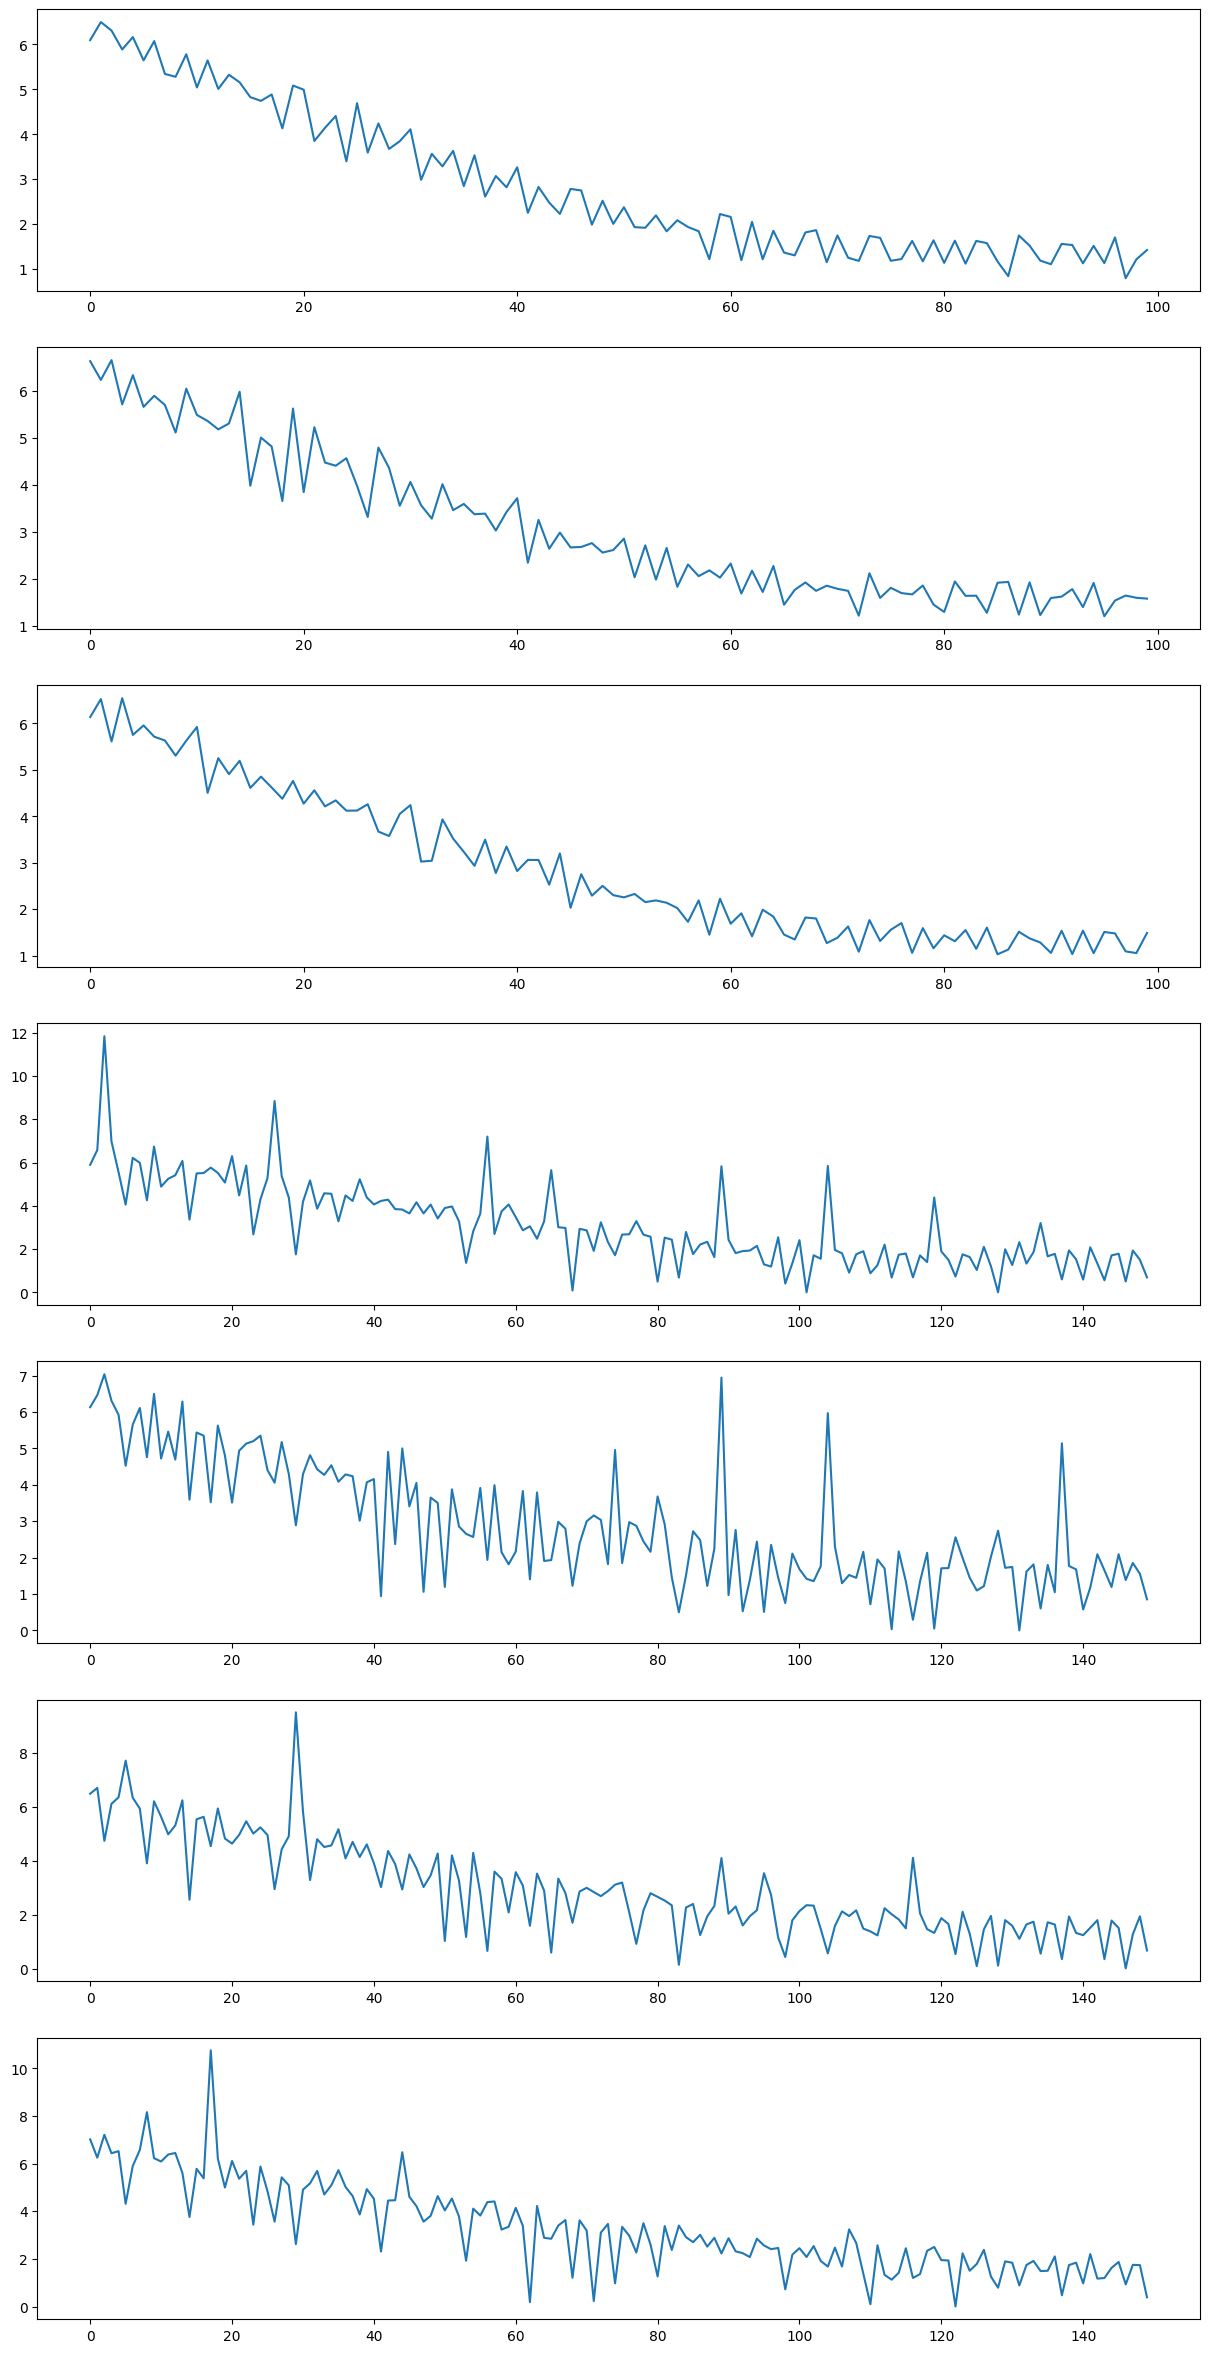

In [105]:
cross_validate(UV_dataset)

Fold 0, train loss: 1.756 test loss: 2.006
Fold 1, train loss: 2.032 test loss: 1.870
Fold 2, train loss: 1.692 test loss: 2.606
Fold 3, train loss: 0.708 test loss: 1.887
Fold 4, train loss: 0.240 test loss: 1.552
Fold 5, train loss: 0.320 test loss: 1.437
Fold 6, train loss: 0.407 test loss: 2.369
Mean train loss: 1.022
Mean test loss: 1.961


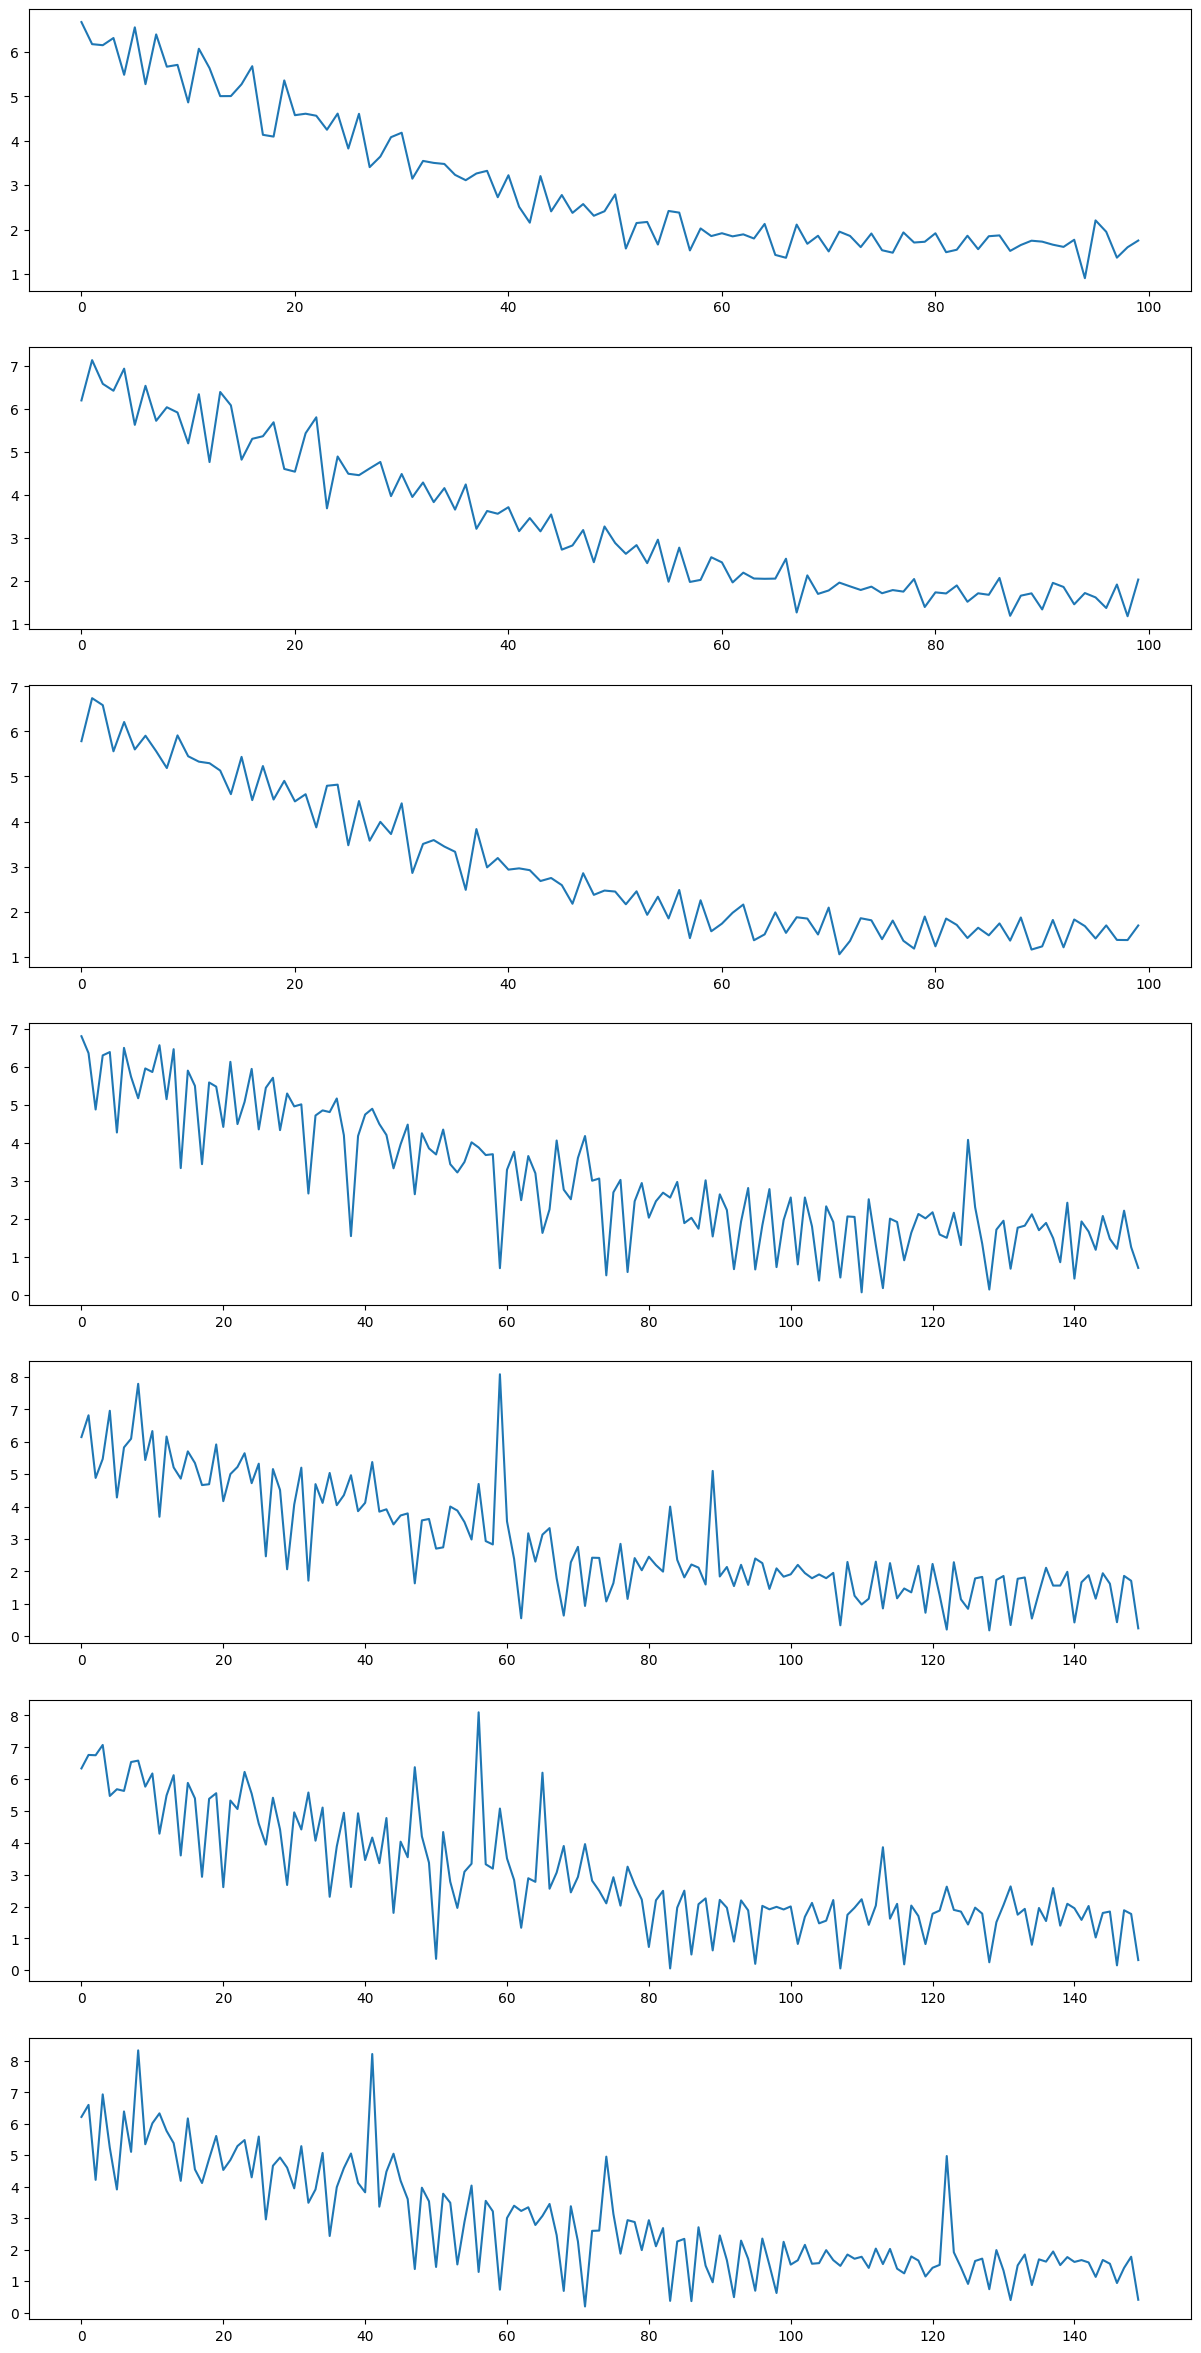

In [106]:
cross_validate(VIS_dataset)

Fold 0, train loss: 1.564 test loss: 2.576
Fold 1, train loss: 2.112 test loss: 1.818
Fold 2, train loss: 1.241 test loss: 2.682
Fold 3, train loss: 1.453 test loss: 1.902
Fold 4, train loss: 0.729 test loss: 1.765
Fold 5, train loss: 0.712 test loss: 1.724
Fold 6, train loss: 0.113 test loss: 1.628
Mean train loss: 1.132
Mean test loss: 2.014


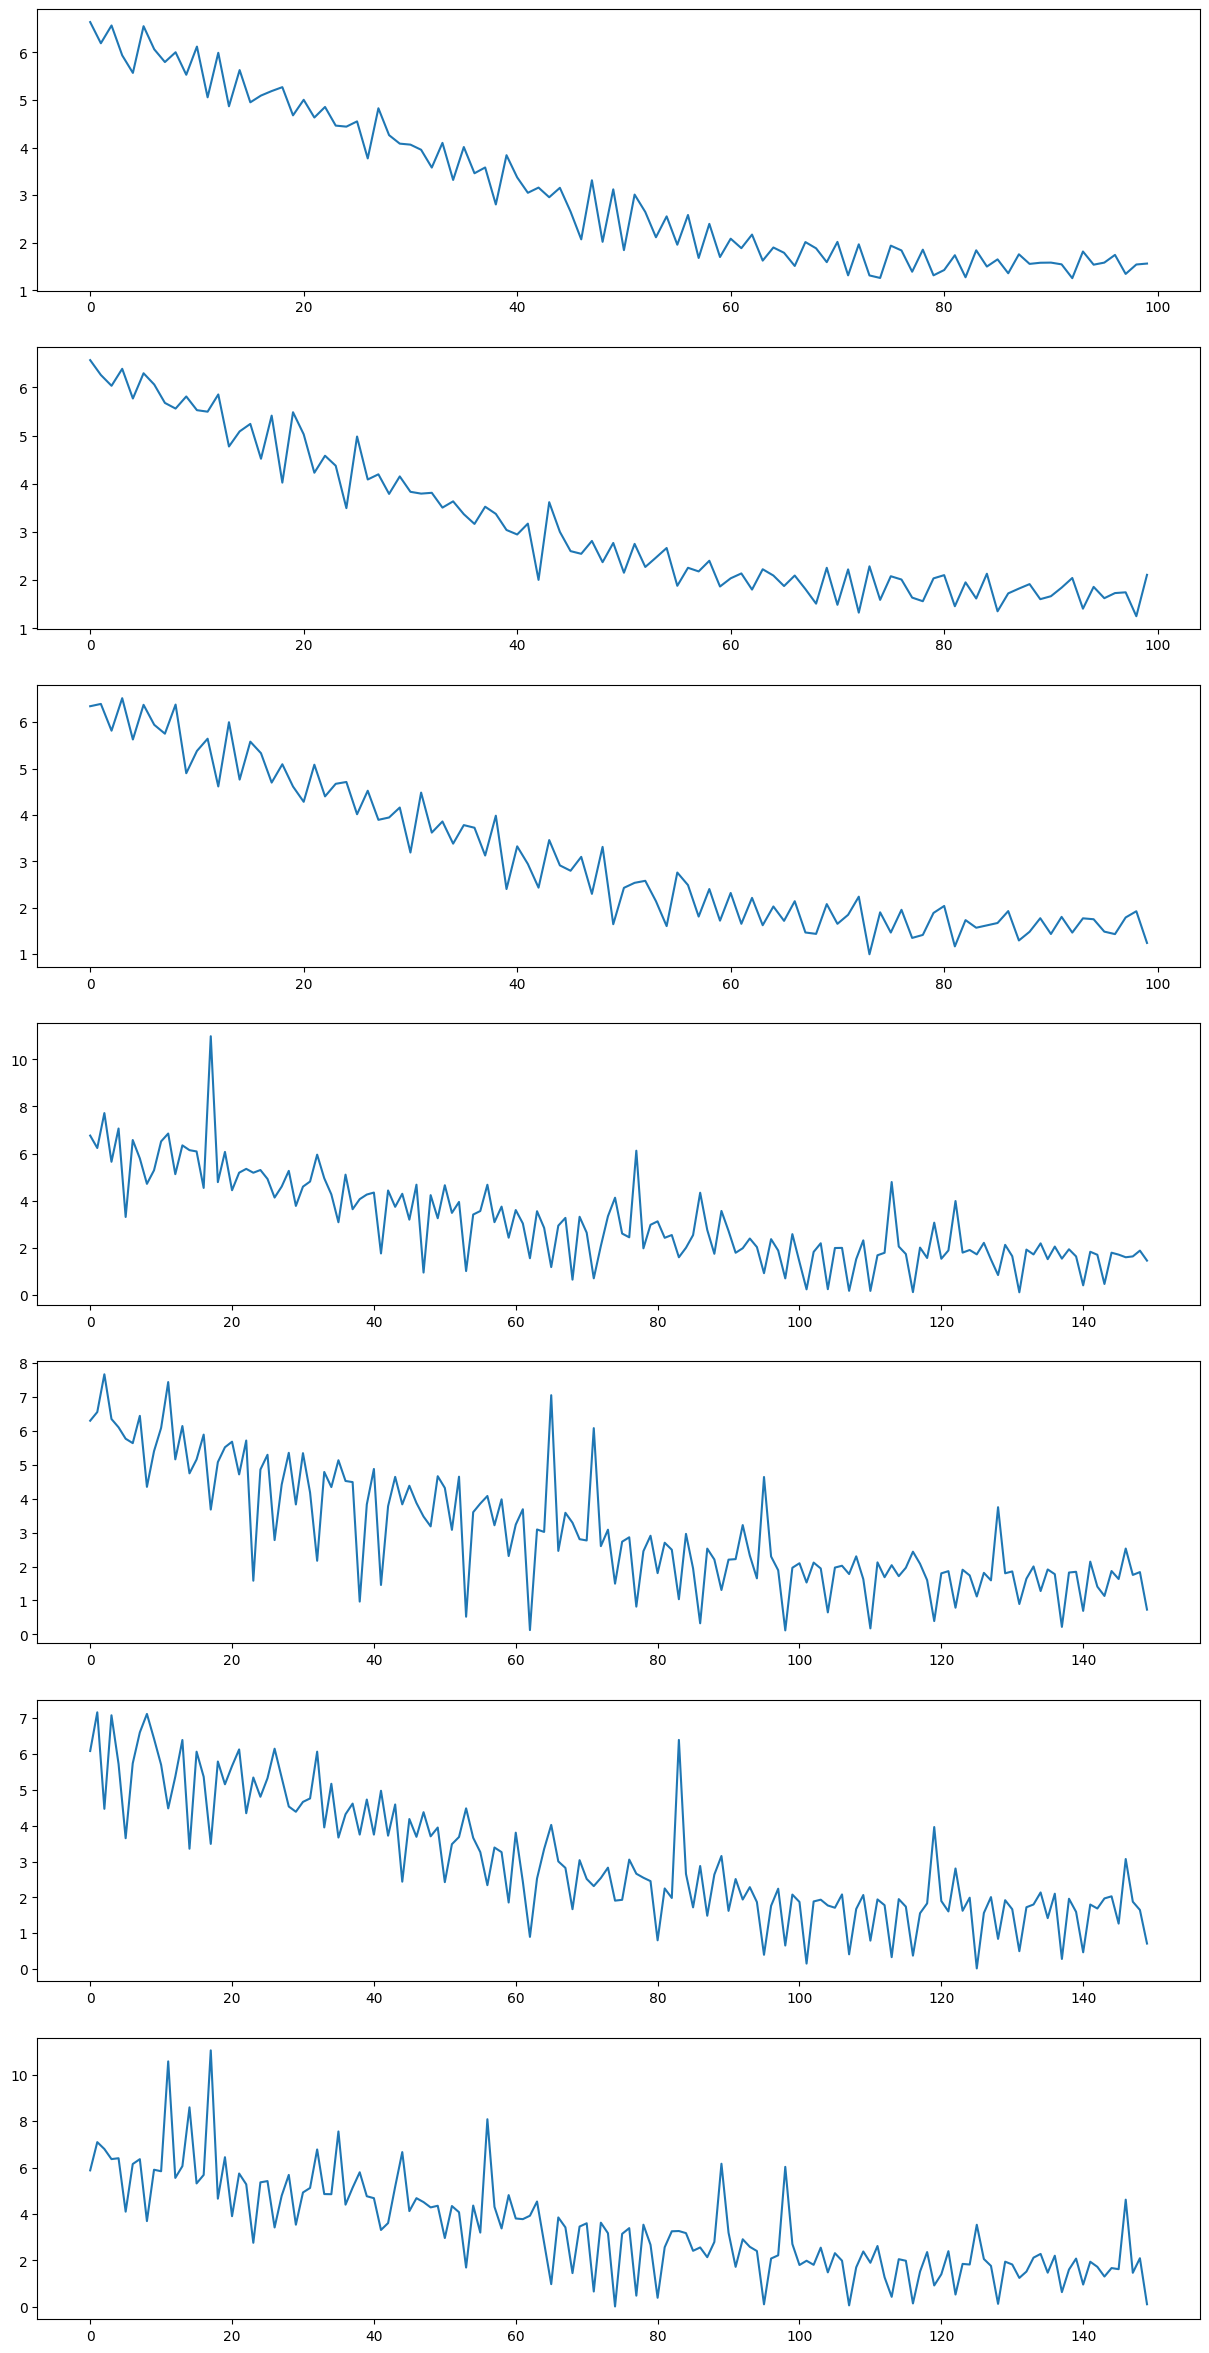

In [108]:
cross_validate(IR_dataset)

In [123]:
def final_train(dataset, type):
    epochs = 40

    trainloader = DataLoader(dataset, batch_size=16)

    loss_function = nn.MSELoss()

    network = MLP()

    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

    network.train(True)

    train_losses = []

    for epoch in range(epochs):

        for i, data in enumerate(trainloader):

            inputs, targets = data

            optimizer.zero_grad()

            outputs = network(inputs)

            loss = loss_function(outputs, targets)

            loss.backward()

            optimizer.step()

            train_losses.append(torch.sqrt(loss).item())
            
    torch.save(network.state_dict(), models_base + f"{type}_neural_network.pt")

    plt.figure(figsize=(15, 5))
    plt.plot(train_losses)
    plt.show()

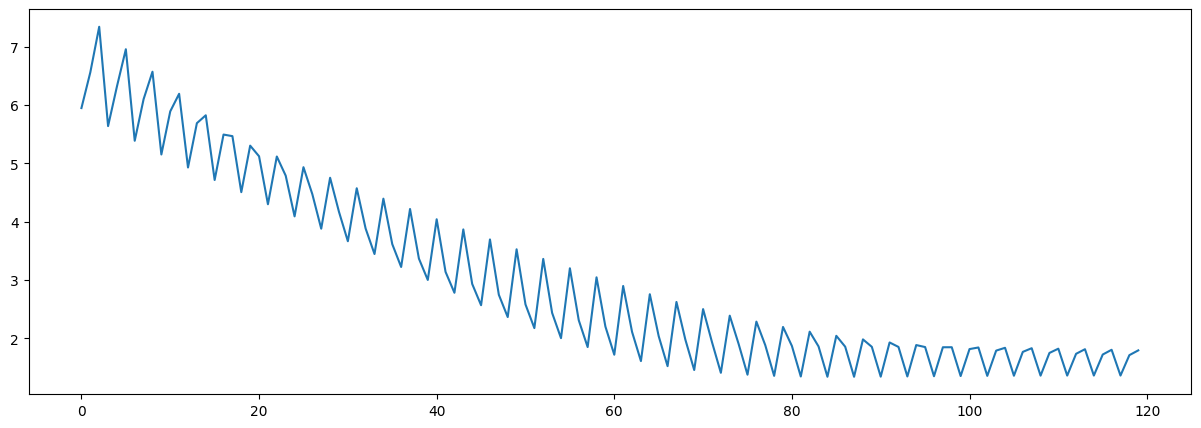

In [124]:
final_train(UV_dataset, "UV")

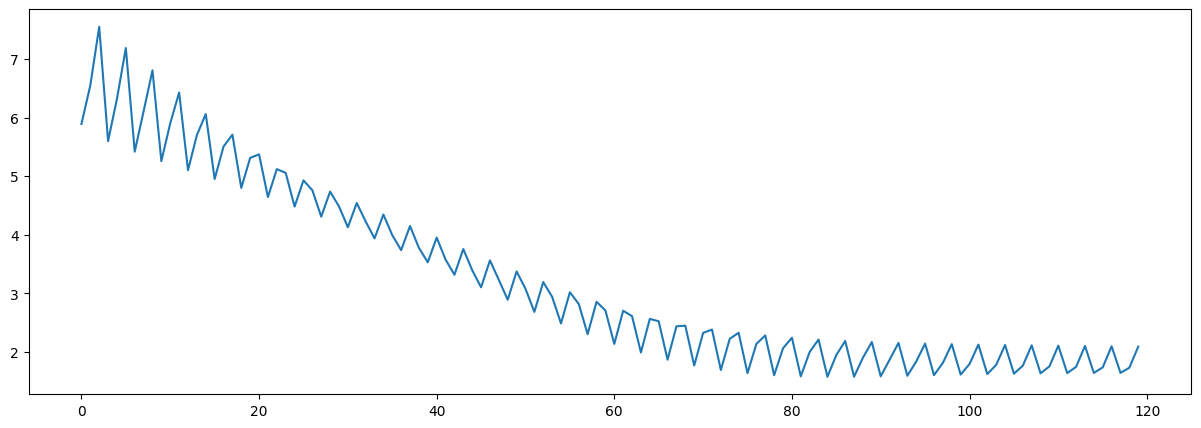

In [125]:
final_train(VIS_dataset, "VIS")

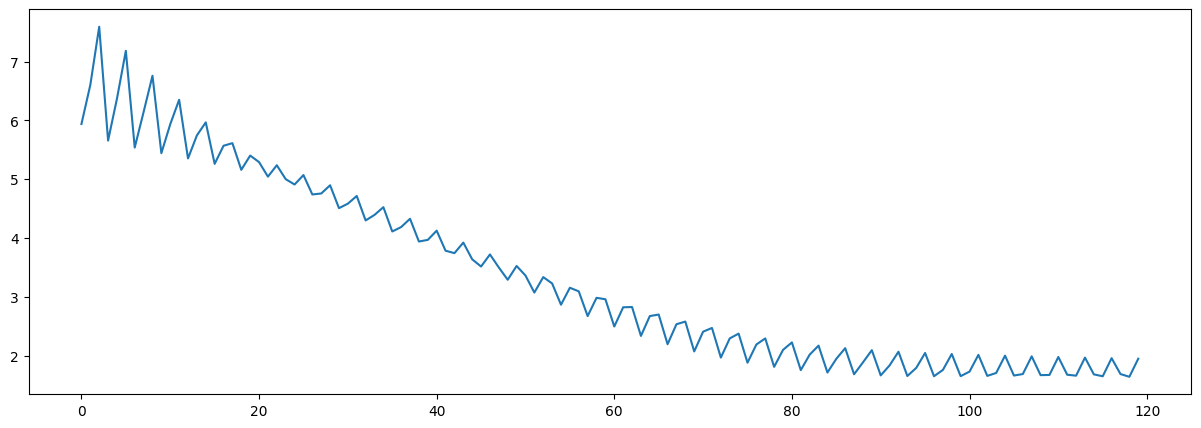

In [126]:
final_train(IR_dataset, "IR")